In [1]:
import torch

%cd ..
from models import FNO2d
from train_utils.datasets import MatReader, BurgersLoader
from train_utils.train_2d import train_2d_burger

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

/home/tp526/neuraloperator/PI-FNO-reproduce


<h2>Load model</h2>

In [24]:
config = {"model": {
              "layers": [64, 64, 64, 64, 64], #[16, 24, 24, 32, 32],
              "modes1": [15, 12, 9, 9],
              "modes2": [15, 12, 9, 9],
              "fc_dim": 128,
              "act": "gelu",
              "num_pad": 4,
            },
          }

In [25]:
model = FNO2d(modes1=config['model']['modes1'],
              modes2=config['model']['modes2'],
              fc_dim=config['model']['fc_dim'],
              layers=config['model']['layers'],
              act=config['model']['act']).to(device)

ckpt_path = "checkpoints/burgers-FDM/burgers-pretrain-eqn-kcut2.pt"
ckpt = torch.load(ckpt_path)
model.load_state_dict(ckpt['model'])

<All keys matched successfully>

<h2>Generate Ground Truths</h2>

Generating 100 samples of Burgers' equation (nu=0.01)...
Processing sample 50/100...
Processing sample 100/100...

Generation complete.
x shape: (100, 128)
y shape: (100, 101, 128)


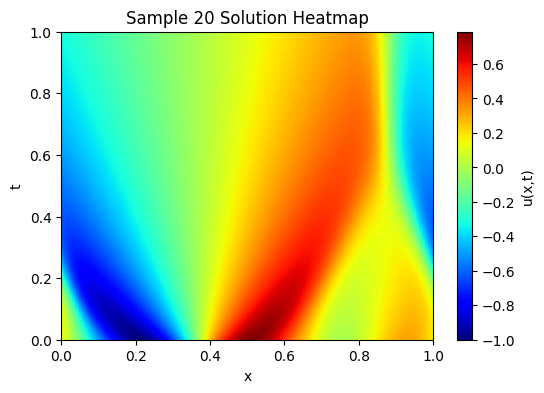

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

def solve_burgers(u0, nu=0.01, Nx=128, Nt=101):
    """
    Solves the viscous Burgers' equation: u_t + u*u_x = nu * u_xx
    Domain: x in [0, 1), t in [0, 1]
    Method: Pseudo-Spectral Method with RK45 time integration.
    """
    # 1. Define Grids
    x = np.linspace(0, 1, Nx, endpoint=False)
    t = np.linspace(0, 1, Nt)
    
    # 2. Define Wavenumbers for FFT
    k = 2 * np.pi * np.fft.fftfreq(Nx, d=1/Nx)
    
    # 3. Define the RHS of the ODE in Fourier Domain
    def burgers_rhs(t, u_hat):
        # Convert to real space to compute non-linear term
        u = np.fft.ifft(u_hat).real
        
        # Compute non-linear term: u * u_x = 0.5 * d(u^2)/dx
        # In Fourier space: 0.5 * i * k * FFT(u^2)
        u2 = u**2
        u2_hat = np.fft.fft(u2)
        nonlinear_term = 0.5 * 1j * k * u2_hat
        
        # Compute diffusion term: nu * u_xx
        # In Fourier space: -nu * k^2 * u_hat
        diffusion_term = -nu * (k**2) * u_hat
        
        # Combined: u_t = -u*u_x + nu*u_xx
        d_uhat_dt = -nonlinear_term + diffusion_term
        return d_uhat_dt
    
    # 4. Integrate
    u0_hat = np.fft.fft(u0)
    
    solution = solve_ivp(
        burgers_rhs,
        t_span=(0, 1),
        y0=u0_hat,
        t_eval=t,
        method='RK45'
    )
    
    # 5. Reconstruct solution in Real Space
    u_hat_sol = solution.y.T # Shape (Nt, Nx)
    u_sol = np.fft.ifft(u_hat_sol, axis=1).real
    
    return u_sol, x, t

def generate_ic(Nx, freq_cut=2):
    """
    Generates a random periodic initial condition using
    low frequency modes up to `freq_cut`.
    """
    x = np.linspace(0, 1, Nx, endpoint=False)
    u0 = np.zeros(Nx)
    
    for k in range(1, freq_cut + 1):
        a_k = np.random.uniform(-1, 1)
        b_k = np.random.uniform(-1, 1)
        u0 += a_k * np.sin(2 * np.pi * k * x) + b_k * np.cos(2 * np.pi * k * x)
        
    u0 = u0 / np.max(np.abs(u0))
    return u0

def create_burgers_dataset(N_SAMPLES=200, Nx=128, Nt=101, NU=0.01, FREQ_CUT=2):
    """
    Generates dataset and returns dictionary with NumPy arrays.
    """
    print(f"Generating {N_SAMPLES} samples of Burgers' equation (nu={NU})...")
    
    # Pre-allocate arrays
    x_data = np.zeros((N_SAMPLES, Nx))      # To store Initial Conditions
    y_data = np.zeros((N_SAMPLES, Nt, Nx))  # To store Solutions
    
    for i in range(N_SAMPLES):
        if (i+1) % 50 == 0:
            print(f"Processing sample {i+1}/{N_SAMPLES}...")
            
        # 1. Generate IC
        u0 = generate_ic(Nx, FREQ_CUT)
        
        # 2. Solve
        u_sol, _, _ = solve_burgers(u0, NU, Nx, Nt)
        
        # 3. Store
        x_data[i] = u0
        y_data[i] = u_sol

    # 4. Pack into dictionary (NumPy arrays only)
    burgers_128 = {
        'x': x_data,
        'y': y_data,
        'visc': np.array([[NU]])
    }
    
    print("\nGeneration complete.")
    print(f"x shape: {burgers_128['x'].shape}")
    print(f"y shape: {burgers_128['y'].shape}")
    
    return burgers_128

# --- Example Usage ---
if __name__ == "__main__":
    # Generate data
    data_dict = create_burgers_dataset(N_SAMPLES=100, Nx=128, Nt=101, FREQ_CUT=2)
    
    # Verification Plot
    sample_idx = np.random.randint(100)
    u_field = data_dict['y'][sample_idx]
    
    plt.figure(figsize=(6, 4))
    plt.imshow(u_field, extent=[0, 1, 0, 1], origin="lower", aspect="auto", cmap="jet")
    plt.colorbar(label="u(x,t)")
    plt.title(f"Sample {sample_idx} Solution Heatmap")
    plt.xlabel("x")
    plt.ylabel("t")
    plt.show()

<h2>Test the model</h2>

In [5]:
def format_burgers_data(data_dict):
    """
    Reshapes the Burgers dataset into a coordinate-based format.
    
    Args:
        data_dict (dict): Dictionary with keys 'x' (N, Nx) and 'y' (N, Nt, Nx).
        
    Returns:
        np.array: A single array of shape (N_SAMPLES, Nt, Nx, 3).
                  Channel 0: u0(x) repeated over time
                  Channel 1: x coordinates
                  Channel 2: t coordinates
    """
    # 1. Extract dimensions
    # data_dict['x'] is the initial condition u0, shape (N, Nx)
    # data_dict['y'] is the solution u, shape (N, Nt, Nx)
    u0 = data_dict['x'] 
    N_samples, Nx = u0.shape
    Nt = data_dict['y'].shape[1]
    
    print(f"Dimensions detected: N={N_samples}, Nt={Nt}, Nx={Nx}")

    # 2. Create Mesh Grids (Nt, Nx)
    # Recreate the grids used in the solver
    x_1d = np.linspace(0, 1, Nx, endpoint=False)
    t_1d = np.linspace(0, 1, Nt)
    
    # Create 2D grids. indexing='ij' ensures output is (Nt, Nx)
    # T_grid varies along axis 0, X_grid varies along axis 1
    T_grid, X_grid = np.meshgrid(t_1d, x_1d, indexing='ij')
    
    # 3. Broadcast/Repeat Arrays to shape (N, Nt, Nx)
    
    # Channel 0: u0 (Initial Condition)
    # Input: (N, Nx) -> Expand to (N, 1, Nx) -> Tile to (N, Nt, Nx)
    u0_expanded = np.tile(u0[:, None, :], (1, Nt, 1))
    
    # Channel 1: X Grid
    # Input: (Nt, Nx) -> Expand to (1, Nt, Nx) -> Broadcast to (N, Nt, Nx)
    X_expanded = np.tile(X_grid[None, :, :], (N_samples, 1, 1))
    
    # Channel 2: T Grid
    # Input: (Nt, Nx) -> Expand to (1, Nt, Nx) -> Broadcast to (N, Nt, Nx)
    T_expanded = np.tile(T_grid[None, :, :], (N_samples, 1, 1))
    
    # 4. Stack along the last axis
    # Result shape: (N, Nt, Nx, 3, 1)
    formatted_data = np.stack([u0_expanded, X_expanded, T_expanded], axis=-1)
    
    return formatted_data

In [32]:
formatted_inputs = format_burgers_data(data_dict)
formatted_inputs.shape

Dimensions detected: N=100, Nt=101, Nx=128


(100, 101, 128, 3)

Input shape:  torch.Size([1, 101, 128, 3])
Output shape:  torch.Size([1, 101, 128])


==Relative L2 error mean:  0.007938==

Ground Truth


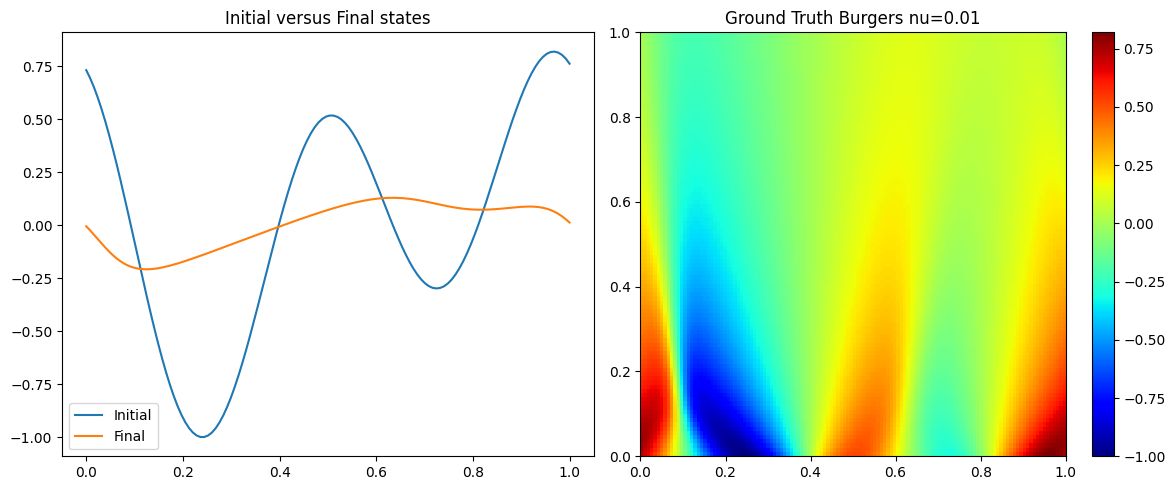

Prediction


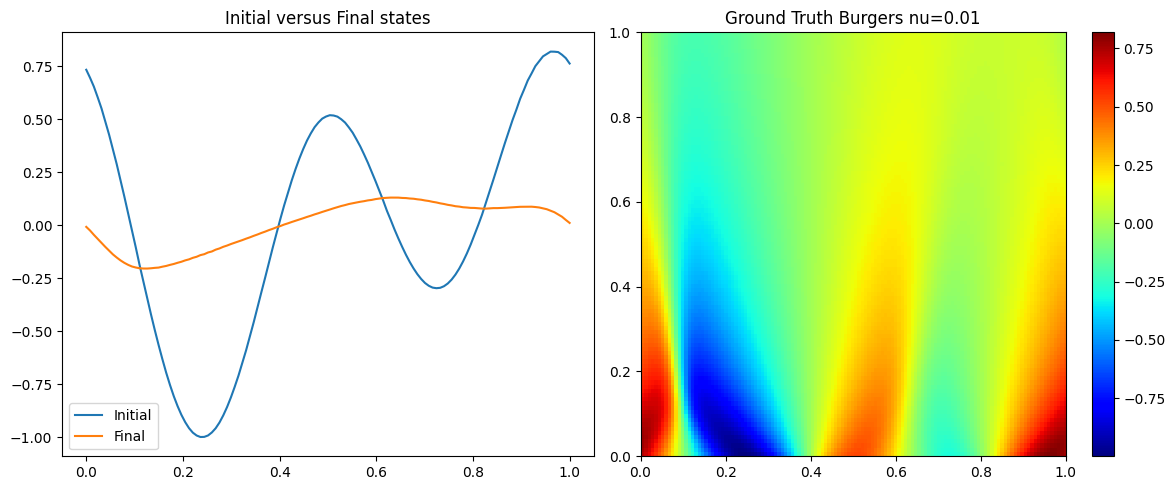

In [36]:
k = np.random.randint(100)

x, y = torch.tensor(formatted_inputs[k:k+1], dtype=torch.float32).to(device), torch.tensor(data_dict["y"][k:k+1], dtype=torch.float32).to(device)

print("Input shape: ", x.shape)
print("Output shape: ", y.shape)
print("\n")

out = model(x).reshape(y.shape)

data_loss = torch.norm(out - y) / torch.norm(y)

print(f'==Relative L2 error mean: {data_loss.item() : .6f}==\n')

# Plot
print("Ground Truth")
truth = y[0].detach().cpu().numpy()
x_grid = np.linspace(0, 1, truth.shape[1])

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(x_grid, truth[0], label="Initial")
plt.plot(x_grid, truth[-1], label="Final")
plt.title("Initial versus Final states")
plt.legend()

plt.subplot(1, 2, 2)
plt.imshow(truth, extent=[0, 1, 0, 1], origin="lower", aspect="auto", cmap="jet")
plt.title("Ground Truth Burgers nu=0.01")
plt.colorbar()

plt.tight_layout()
plt.show()

print("Prediction")
pred = out[0].detach().cpu().numpy()

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(x_grid, pred[0], label="Initial")
plt.plot(x_grid, pred[-1], label="Final")
plt.title("Initial versus Final states")
plt.legend()

plt.subplot(1, 2, 2)
plt.imshow(pred, extent=[0, 1, 0, 1], origin="lower", aspect="auto", cmap="jet")
plt.title("Ground Truth Burgers nu=0.01")
plt.colorbar()

plt.tight_layout()
plt.show()



In [31]:
dataset = BurgersLoader("/home/tp526/neuraloperator/data/burgers_pino.mat",
                            nx=128, nt=100,
                            sub=1, sub_t=1, new=True)
train_loader = dataset.make_loader(n_sample=10,
                                    batch_size=1,
                                    start=0)

/home/tp526/.conda/envs/dde/lib/python3.11/site-packages/scipy/io/matlab/_mio.py:235: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Considerscipy.io.matlab.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


In [32]:
for batch in train_loader:
    x, y = batch
    print(x.shape)

torch.Size([1, 101, 128, 3])
torch.Size([1, 101, 128, 3])
torch.Size([1, 101, 128, 3])
torch.Size([1, 101, 128, 3])
torch.Size([1, 101, 128, 3])
torch.Size([1, 101, 128, 3])
torch.Size([1, 101, 128, 3])
torch.Size([1, 101, 128, 3])
torch.Size([1, 101, 128, 3])
torch.Size([1, 101, 128, 3])


In [23]:
import scipy

# We map 'x' -> 'input' and 'y' -> 'output'
mat_data = {
    'input': data_dict['x'],
    'output': data_dict['y'],
    'visc': data_dict['visc']
}

# 3. Save to .mat file
# do_compression=True helps if the arrays are large
scipy.io.savemat('/home/tp526/neuraloperator/data/burgers_pino_new.mat', mat_data, do_compression=True)

print("Saved to /home/tp526/neuraloperator/data/burgers_pino_new.mat")

Saved to /home/tp526/neuraloperator/data/burgers_pino_new.mat


In [37]:
print("-" * 100)
print("\nNumber of trainable parameters: ", sum(p.numel() for p in model.parameters()))
print("\n" + "-" * 100)

----------------------------------------------------------------------------------------------------

Number of trainable parameters:  4383489

----------------------------------------------------------------------------------------------------
